In [49]:
import pandas as pd
import numpy as np
df=pd.read_csv("market-price.csv")
df.head(3)

,Timestamp,market-price
0,2021-08-30 00:00:00,48806.78
1,2021-08-31 00:00:00,47074.77
2,2021-09-01 00:00:00,47155.87


In [50]:
import warnings
warnings.filterwarnings('ignore')

series=pd.read_csv("market-price.csv", header=0, names=['day', 'price'])

series['day']=pd.to_datetime(series['day'])
series.set_index('day', inplace=True)
series.head(3)

,price
day,
2021-08-30,48806.78
2021-08-31,47074.77
2021-09-01,47155.87


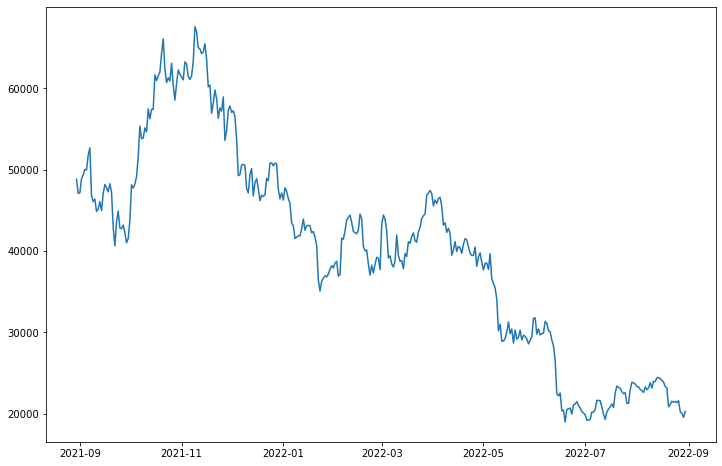

In [51]:
import matplotlib.pyplot as plt
plt.plot(series.index, series['price'])

In [53]:
import matplotlib.pyplot as plt
def plot_rolling(data, interval):
    rolmean=data.rolling(interval).mean()
    rolstd=data.rolling(interval).std()
    
    plt.figure(figsize=(10,6))
    plt.xlabel('Date')
    orig=plt.plot(data, color='blue', label='Original')
    mean=plt.plot(rolmean, color='red', label='Rolling Mean')
    std=plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.show()

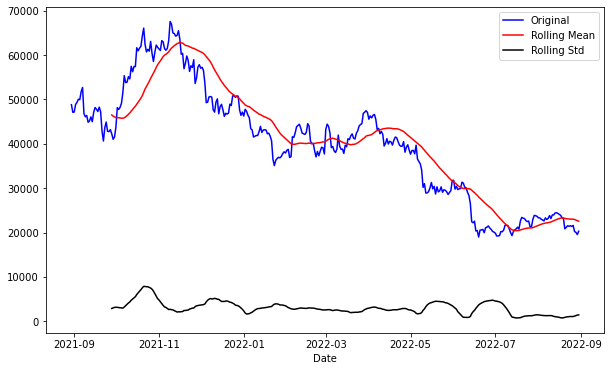

In [11]:
plot_rolling(series, 30)

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
result=sm.tsa.seasonal_decompose(series, model='additive')
plt.rcParams['figure.figsize']=[12,8]

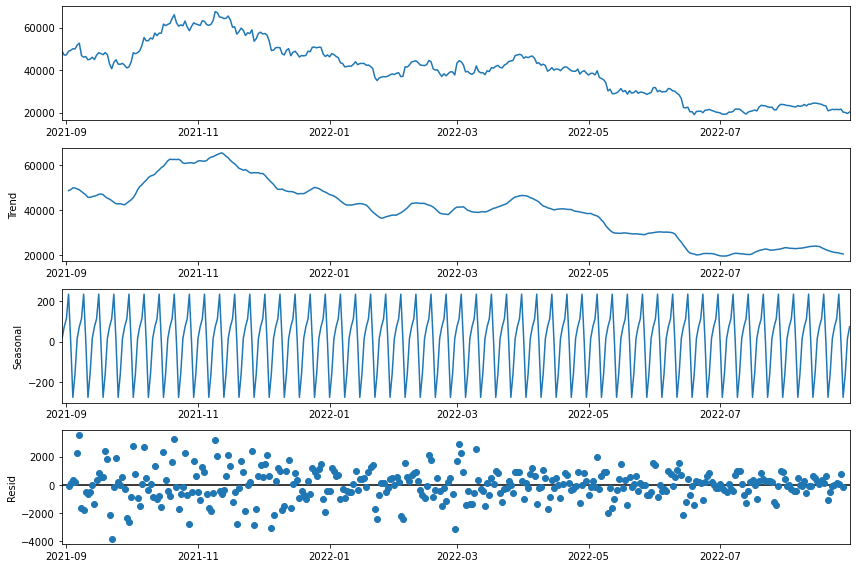

In [14]:
result.plot()
plt.show()

- 시계열 정상성 여부 분석

In [16]:
from statsmodels.tsa.stattools import kpss

def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values=kpss(series, **kw)
    
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    
    for key, value in critical_values.items():
        print(f' {key}:{value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""} stationary')          

In [19]:
#warinng 무시
import warnings
warnings.filterwarnings('ignore')

kpss_test(series)

KPSS Statistic: 1.7508916324536314
p-value: 0.01
num lags: 17
Critial Values:
 10%:0.347
 5%:0.463
 2.5%:0.574
 1%:0.739
Result: The series is not  stationary


귀무가설을 기각한다. 즉 비정상 시계열이다.

- 비정상 시계열 확인(ACF 그래프)

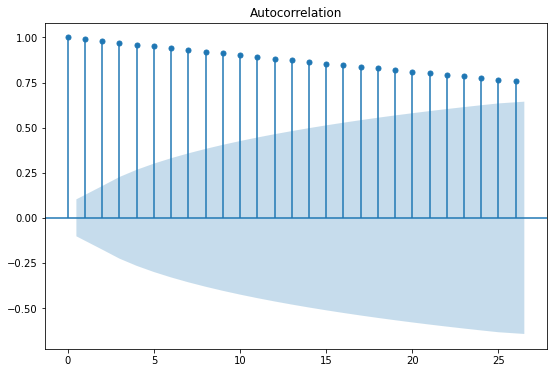

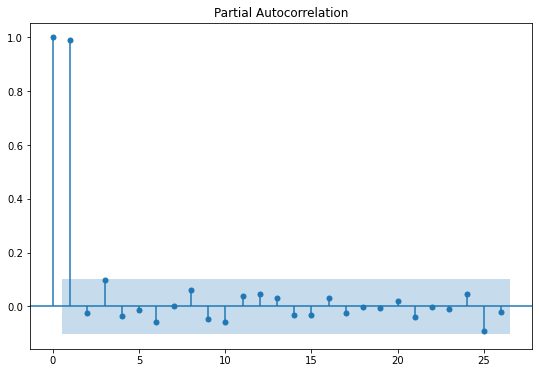

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams['figure.figsize']=[9,6]
plot_acf(series)
plot_pacf(series)
plt.show()

KPSS Statistic: 0.10758206974907136
p-value: 0.1
num lags: 17
Critial Values:
 10%:0.347
 5%:0.463
 2.5%:0.574
 1%:0.739
Result: The series is  stationary
None


<AxesSubplot:xlabel='day'>

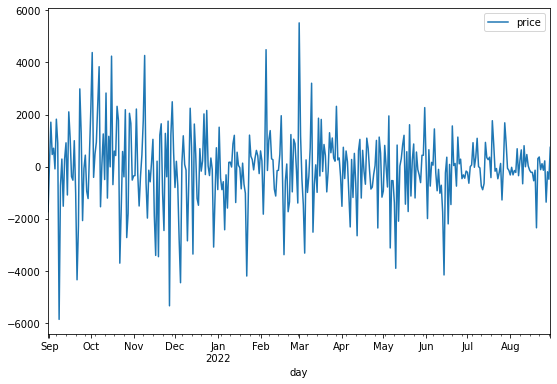

In [21]:
diff_1=series.diff(periods=1).iloc[1:]

print(kpss_test(diff_1))
diff_1.plot()

정상성 만족

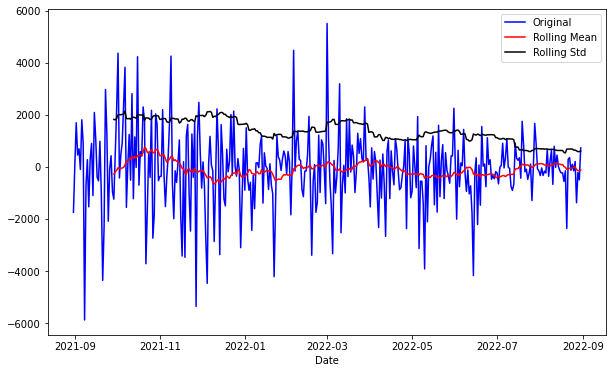

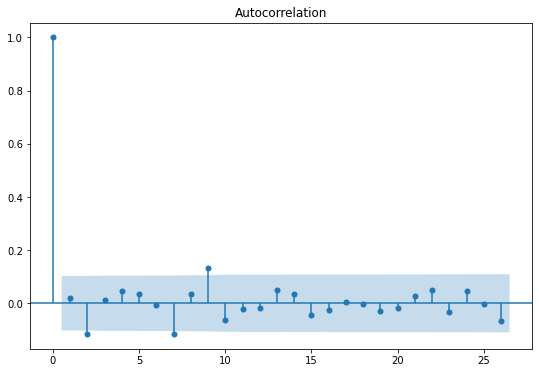

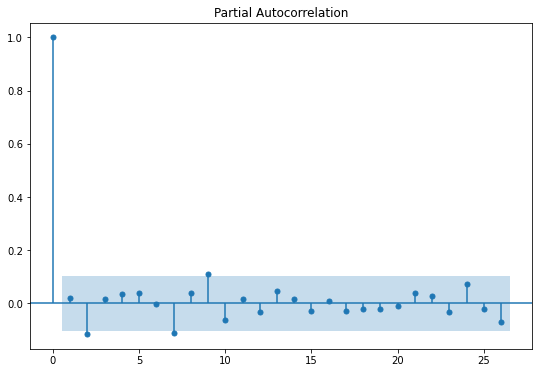

In [22]:
plot_rolling(diff_1, 30)
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

In [23]:
from statsmodels.tsa.stattools import adfuller
result=adfuller(series)
print(result[0])
print(result[1])

-0.641132001173393
0.8614144431327684


p-value가 0.05보다 커 귀무가설을 기각할 수 없다.

In [25]:
result=adfuller(diff_1)
print(result[0])
print(result[1])

-14.91051755076732
1.4608485303225722e-27


p-value가 0.05보다 작아 귀무가설을 기각한다.

### ARIMA 예측모형 생성

In [26]:
from statsmodels.tsa.arima_model import ARIMA

#AR=0, 차본=1, MA=1
model=ARIMA(series, order=(0,1,1))

model_fit=model.fit(trend='c', full_output=True, disp=1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                  365
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3175.080
Method:                       css-mle   S.D. of innovations           1450.859
Date:                Tue, 22 Nov 2022   AIC                           6356.161
Time:                        18:22:54   BIC                           6367.861
Sample:                    08-31-2021   HQIC                          6360.810
                         - 08-30-2022                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -78.1270     77.814     -1.004      0.315    -230.641      74.386
ma.L1.D.price     0.0247      0.060      0.414      0.679      -0.092       0.142
                                    Root

In [27]:
model=ARIMA(series, order=(0,1,0))
model_fit=model.fit(trend='c', full_output=True, disp=1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                  365
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -3175.166
Method:                           css   S.D. of innovations           1451.202
Date:                Tue, 22 Nov 2022   AIC                           6354.333
Time:                        18:28:41   BIC                           6362.132
Sample:                    08-31-2021   HQIC                          6357.432
                         - 08-30-2022                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -78.1270     75.959     -1.029      0.304    -227.005      70.751


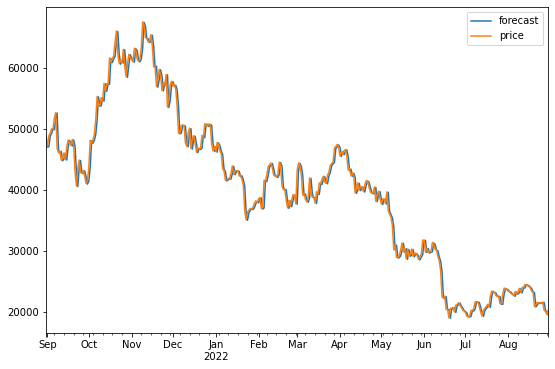

In [28]:
model_fit.plot_predict()
plt.show()

과대적합은 없는 것 같음

In [29]:
fore=model_fit.forecast(steps=5)
print(fore)

(array([20212.2829589 , 20134.15591781, 20056.02887671, 19977.90183562,
       19899.77479452]), array([1451.20150206, 2052.30884595, 2513.55473358, 2902.40300412,
       3244.98520765]), array([[17367.98028056, 23056.58563725],
       [16111.7044946 , 24156.60734102],
       [15129.55212572, 24982.50562771],
       [14289.29647893, 25666.5071923 ],
       [13539.72065716, 26259.82893188]]))


### 책 시계열 연습

In [67]:
import pandas as pd
import warnings

df=pd.read_csv("arima_data.csv", names=['day', 'price'])
df.head(3)

,day,price
0,2013-01-01,3794
1,2013-02-01,3863
2,2013-03-01,5190


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   day     60 non-null     object
 1   price   60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [69]:
df['day']=pd.to_datetime(df['day'], format="%Y-%m-%d")
df.set_index('day', inplace=True)
df.head(3)

,price
day,
2013-01-01,3794
2013-02-01,3863
2013-03-01,5190


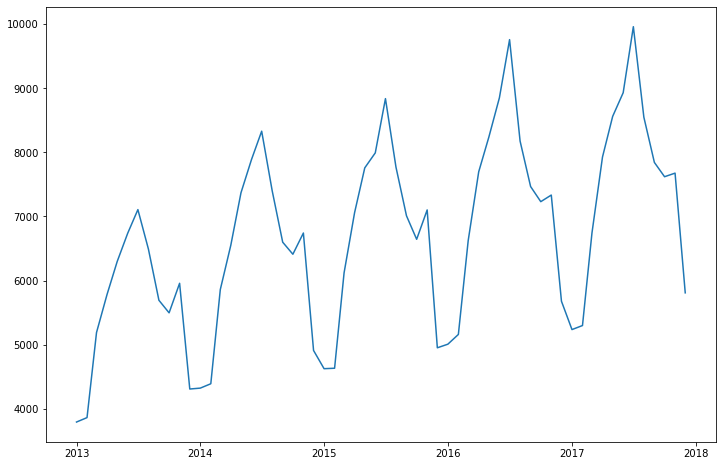

In [70]:
import matplotlib.pyplot as plt
plt.plot(df.index, df['price'])

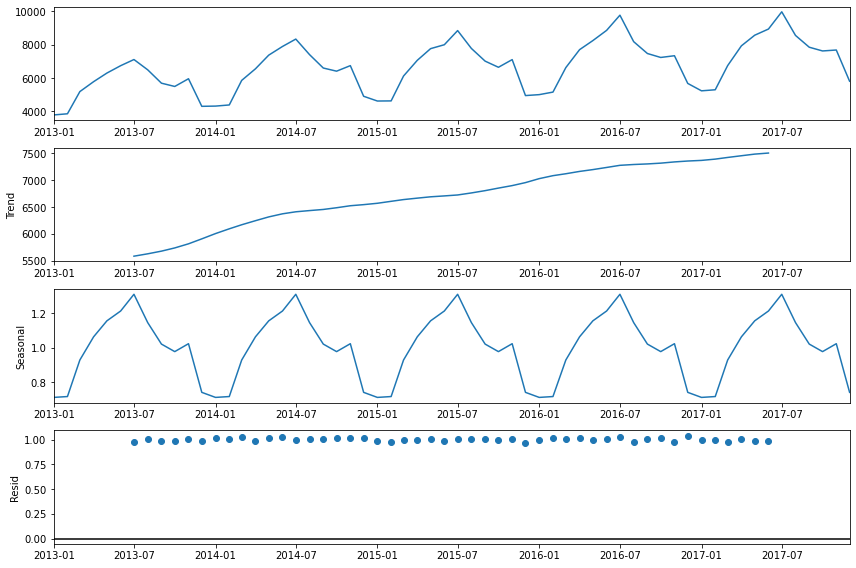

In [71]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

result=sm.tsa.seasonal_decompose(df, model='multiplicative')
plt.rcParams['figure.figsize']=[12,8]
result.plot()
plt.show()

In [72]:
from statsmodels.tsa.stattools import adfuller

#train/test 분리
training=df[:"2016-12-01"]
test=df.drop(training.index)

adf=adfuller(training, regression='ct')
print(adf[1])

0.6015863303794268


귀무가설을 기각할 수 없다. 즉 비정상 시계열이다. -> 차분 진행

In [73]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

diff_data=training.diff(1)

<AxesSubplot:xlabel='day'>

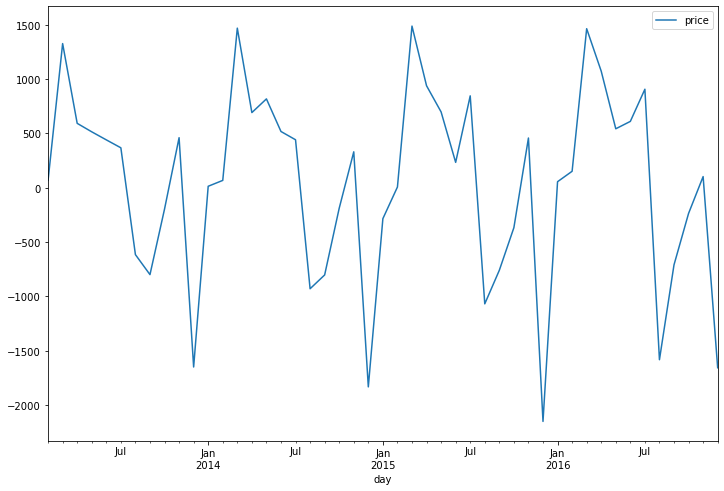

In [74]:
diff_data=diff_data.dropna()
diff_data.plot()

In [75]:
adf=adfuller(diff_data)
print(adf[1])

2.0851606399610975e-22


기각한다. 즉 정상성이다.

-> 즉 차분은 1번 진행

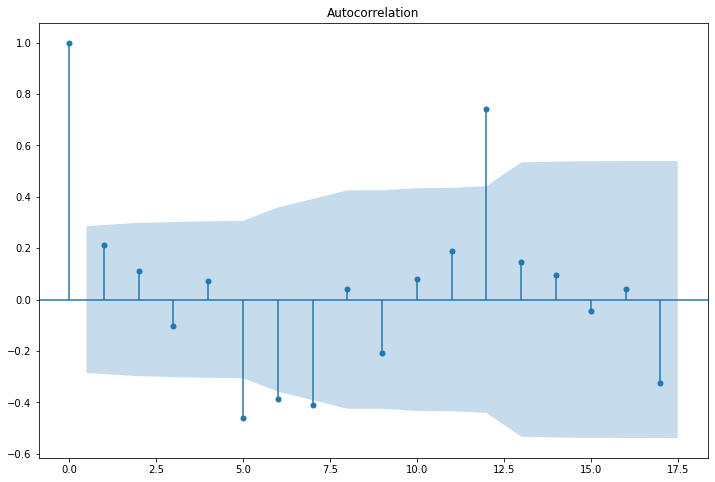

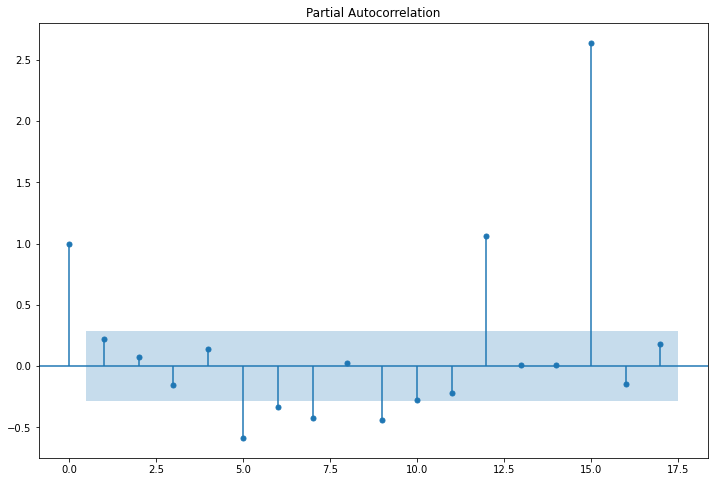

In [76]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plot_acf(diff_data)
plot_pacf(diff_data)
plt.show()

p,q다 2로 설정

p,d,q=2,1,2

In [83]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(training, order=(2,1,2))
res=model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                   48
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -375.875
Date:                Tue, 22 Nov 2022   AIC                            761.750
Time:                        20:06:39   BIC                            771.001
Sample:                    01-01-2013   HQIC                           765.231
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3168      0.190     -6.942      0.000      -1.689      -0.945
ar.L2         -0.3191      0.190     -1.676      0.094      -0.692       0.054
ma.L1          1.9700      0.242      8.125      0.000       1.495       2.445
ma.L2          0.9950      0.241      4.128      0.000       0.523       1.467
sigma2      4.452e+05   1.13e-06   3.93e+11      0.000    4.45e+05    4.45e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.38
Prob(Q):                              0.74   Prob(JB):                         0.83
Heteroskedasticity (H):               1.49   Skew:                            -0.21
Prob(H) (two-sided):                  0.44   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.83e+26. Standard errors may be unstable.
"""

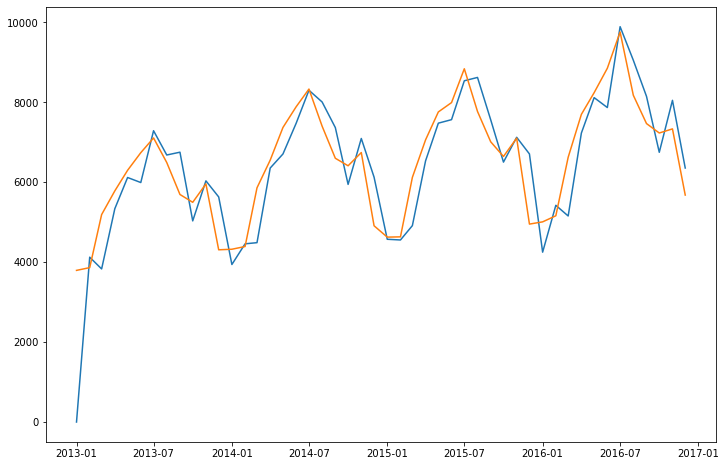

In [84]:
plt.plot(res.predict())
plt.plot(training)

In [85]:
forecast_data=res.forecast(steps=len(test), alpha=0.05)

pred_y=forecast_data
pred_y

2017-01-01    5830.632962
2017-02-01    5508.453766
2017-03-01    5883.976448
2017-04-01    5492.321773
2017-05-01    5888.194496
2017-06-01    5491.915944
2017-07-01    5887.382735
2017-08-01    5493.114358
2017-09-01    5886.063773
2017-10-01    5494.468659
2017-11-01    5884.701410
2017-12-01    5495.830358
Freq: MS, Name: predicted_mean, dtype: float64

In [88]:
#원본 test데이터
test_y=test
test_y

,price
day,
2017-01-01,5236
2017-02-01,5299
2017-03-01,6744
2017-04-01,7927
2017-05-01,8561
2017-06-01,8930
2017-07-01,9960
2017-08-01,8548
2017-09-01,7843


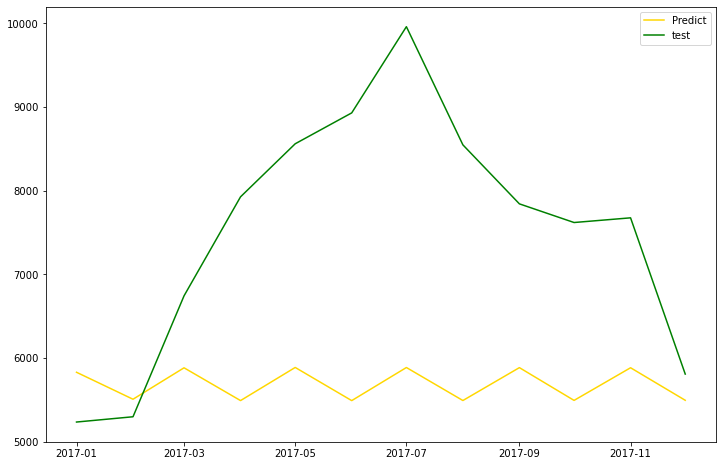

In [91]:
plt.plot(pred_y, color='gold', label='Predict')
plt.plot(test_y, color='green', label='test')
plt.legend()
plt.show()

In [92]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print(r2_score(test_y, pred_y))
RMSE=mean_squared_error(test_y, pred_y)**0.5
print("RMSE :", RMSE)

-1.64291725782009
RMSE : 2302.207554223674


In [93]:
from pmdarima import auto_arima

In [94]:
from pmdarima import auto_arima

auto_model=auto_arima(training, start_p=0, d=1, start_1=0, max_p=3, max_q=3, start_P=0, start_Q=0, max_P=3, max_Q=3, m=12, seasonal=True, information_criterion='aic', trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=482.683, Time=0.27 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=481.846, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=482.652, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=482.466, Time=0.30 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=483.637, Time=0.16 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=483.669, Time=0.11 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.60 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=481.031, Time=0.10 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=482.740, Time=0.27 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.80 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=482.616, Time=0.21 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=482.682, Time=0.45 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=480.687, Time=0.09 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=482.403, Time=0.32 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AI

AIC가 가장 작은 모형은 ARIMA(0,1,1)(0,1,0)[12]

In [95]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -238.344
Date:                             Tue, 22 Nov 2022   AIC                            480.687
Time:                                     20:27:54   BIC                            483.798
Sample:                                 01-01-2013   HQIC                           481.761
                                      - 12-01-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3185      0.177     -1.801      0.072      -0.665       0.028
sigma2      4.803e+04   1.64e+04      2.924      0.003    1.58e+04    8.02e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.15
Prob(Q):                              0.95   Prob(JB):                         0.56
Heteroskedasticity (H):               1.56   Skew:                            -0.14
Prob(H) (two-sided):                  0.45   Kurtosis:                         2.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [97]:
pred_y=auto_model.predict(n_periods=len(test))
pred_y

2017-01-01     5609.436978
2017-02-01     5761.436978
2017-03-01     7225.436978
2017-04-01     8298.436978
2017-05-01     8841.436978
2017-06-01     9452.436978
2017-07-01    10359.436978
2017-08-01     8777.436978
2017-09-01     8068.436978
2017-10-01     7832.436978
2017-11-01     7935.436978
2017-12-01     6279.436978
Freq: MS, dtype: float64

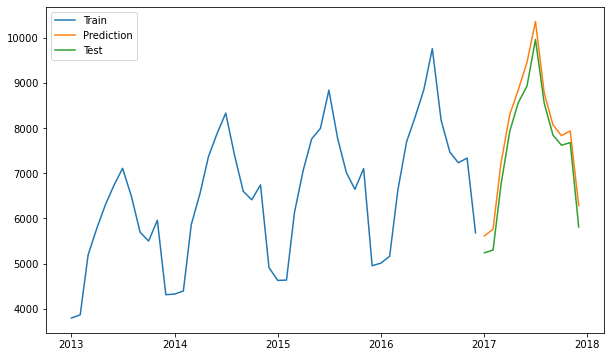

In [98]:
plt.figure(figsize=(10,6))
plt.plot(training, label="Train")
plt.plot(pred_y, label="Prediction")
plt.plot(test, label="Test")
plt.legend(loc='upper left')
plt.show()

In [102]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print(r2_score(test_y, pred_y))
RMSE=mean_squared_error(test_y, pred_y)**0.5
print(RMSE)

0.9305467065490108
373.2064264920625
